# Feature Extraction Explained
This notebook dig into detail of the feature extracted for model training in our module, giving a better overview of the audio data. 

## Install Dependencies

In [145]:
# !pip install librosa numpy soundfile 

## Load Dependencies

In [146]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from mpl_toolkits.mplot3d import Axes3D


## Load Audio

In [147]:
x, sr = librosa.load('audio/speakers/Mendeley Data/differentPhrase/2/2-11.flac', sr=None)
Audio(x, rate=sr)

In [148]:
audio_length = len(x) / sr
print(f"Audio length: {audio_length} seconds")
print(f"Audio Sample Rate: {sr} Hz")

Audio length: 8.533333333333333 seconds
Audio Sample Rate: 48000 Hz


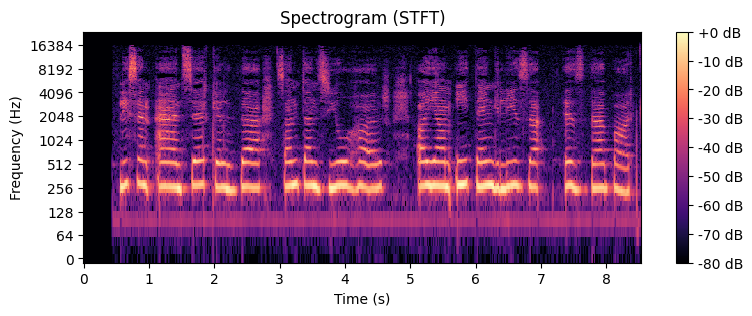

In [238]:
D = librosa.stft(x)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

times = librosa.times_like(S_db, sr=sr)
frequencies = librosa.fft_frequencies(sr=sr)

plt.figure(figsize=(9, 3))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In our report, we resampled the original sample rate from 48000 to 44100 Hz in our training using `soxr_vhq` method. However, in this section, we are going to analyse the Spectral representation using the original Sample Rate which will be 48000 Hz. 

## Zero Crossing Rate
This section discuss one of the important extraction feature in this report - ZCR. 

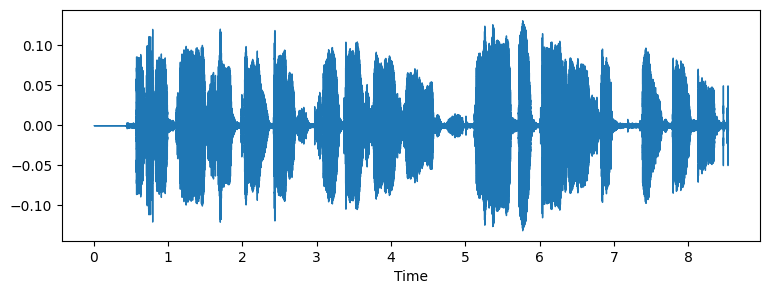

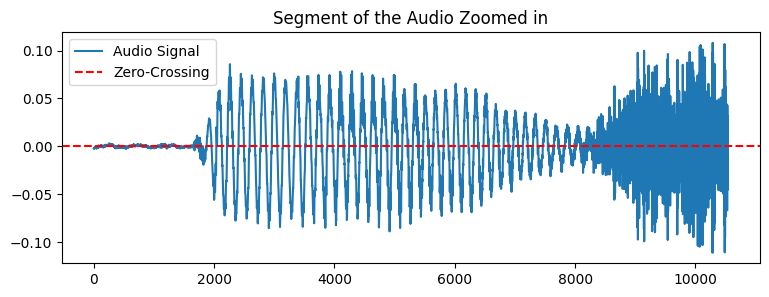

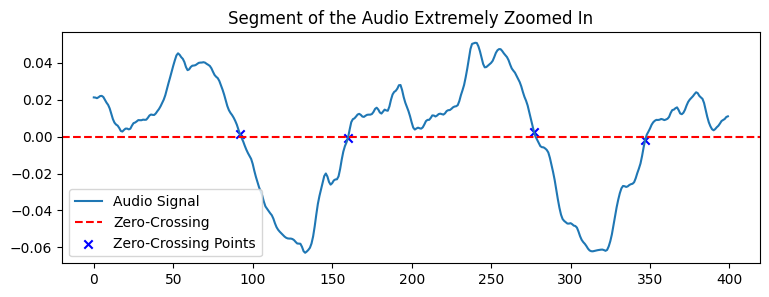

In [149]:
plt.figure(figsize=(9, 3))
librosa.display.waveshow(x, sr=sr)

n0 = 25060
n1 = 35600
plt.figure(figsize=(9, 3))
plt.plot(x[n0:n1], label='Audio Signal')
plt.axhline(0, color='red', linestyle='--', label='Zero-Crossing')
plt.title('Segment of the Audio Zoomed in')
plt.legend()

n0 = 100500
n1 = 100900
segment = x[n0:n1]
plt.figure(figsize=(9, 3))
plt.plot(segment, label='Audio Signal')
plt.axhline(0, color='red', linestyle='--', label='Zero-Crossing')
zero_crossings = np.where(np.diff(np.sign(segment)))[0]
plt.scatter(zero_crossings, segment[zero_crossings], color='blue', marker='x', label='Zero-Crossing Points')
plt.title('Segment of the Audio Extremely Zoomed In')
plt.legend()
plt.show()

### Zero Crossing Rate - Further explained
In the graph above, we can see that the wave plot intersect the zero crossing line <font color='green'>4</font> times. To prove this, we run the librosa's ZCR function to check whether it is true. 

In [150]:
zc = librosa.zero_crossings(x[n0:n1], pad=False)
print(f'sum of zero crossings = {sum(zc)}')

sum of zero crossings = 4


### Zero Crossing Rate - Further explained
It seems that the statement is true, where we can conclude that the zero crossing is indeed the point when the signal crosses the zero-axis, which indicates a situation when the signal changed from positive to negative and the other way around. Next, we are going to apply the time duration with the zero crossing rate function from librosa.  

(1, 801)


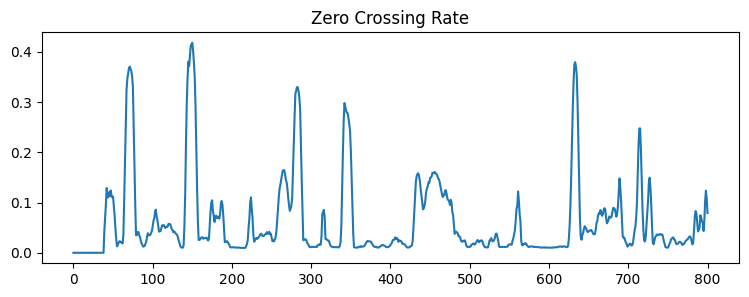

In [151]:
zcr = librosa.feature.zero_crossing_rate(x)
print(zcr.shape)
plt.figure(figsize=(9, 3))
plt.plot(zcr[0])
plt.title('Zero Crossing Rate')
plt.show()

The Zero-Crossing Rate (ZCR) is the rate at which zero crossings occur in an audio signal over time. It is a measure of how often the signal changes sign. The ZCR plot gives a visual representation of how frequently the signal crosses the zero axis. 

References: 
- Shete, D. S., Patil, S. B., & Patil, S. B. (n.d.). Zero crossing rate and Energy of the Speech Signal of Devanagari Script. Iosrjournals.Org. Retrieved July 28, 2024, from https://www.iosrjournals.org/iosr-jvlsi/papers/vol4-issue1/Version-1/A04110105.pdf
- Zero Crossing Rate. (n.d.). Musicinformationretrieval.Com. Retrieved July 29, 2024, from https://musicinformationretrieval.com/zcr.html



## Chroma Short-Time Fourier Transform
This section discuss one of the important extraction feature in this report - Chroma STFT. 

### Understanding Basic FFT before dive into the Chroma STFT

In [212]:
# Default value in librosa
librosa_n_fft = 2048
librosa_sample_rate = 22050

# Physical duration corresponding to 
# n_fft=2048 at 48000 Hz
physical_duration_audio2048 = librosa_n_fft / sr

# n_fft=2048 at 44100 Hz
physical_duration_audio2048_44100 = librosa_n_fft / 44100

# n_fft=2048 at 22050 Hz
physical_duration = librosa_n_fft / librosa_sample_rate

# n_fft=512 at 22050 Hz
n_fft_speech = 512
physical_duration_speech = n_fft_speech / librosa_sample_rate

print(f'Duration (default n_fft in Librosa and {sr} Hz): {physical_duration_audio2048:.5f} seconds')
print(f'Duration (default n_fft in Librosa and 44100 Hz): {physical_duration_audio2048_44100:.5f} seconds')
print(f'Duration (default n_fft and sr in Librosa) : {physical_duration:.5f} seconds')
print(f'Duration (speech n_fft and sr in Librosa) : {physical_duration_speech:.5f} seconds')

Duration (default n_fft in Librosa and 48000 Hz): 0.04267 seconds
Duration (default n_fft in Librosa and 44100 Hz): 0.04644 seconds
Duration (default n_fft and sr in Librosa) : 0.09288 seconds
Duration (speech n_fft and sr in Librosa) : 0.02322 seconds

Length of the windowed signal after padding with zeros (n_fft) based on time window achieved with Librosa Default: 8192
Number of Frequency Bins (2048): 1025
Number of Frequency Bins (512): 257



In [216]:
n_fft_librosa_audio_b4_padding = int(physical_duration*sr)
n_fft_librosa_audio = 2**int(np.ceil(np.log2(n_fft_librosa_audio_b4_padding)))
print(f'Length of the windowed signal after padding with zeros (n_fft) based on time window achieved with Librosa Default: {n_fft_librosa_audio}')

S_nfft_librosa_audio = librosa.stft(x, n_fft=n_fft_librosa_audio, center=False)
num_freq_bins_librosa_audio = S_nfft_librosa_audio.shape[0]
print(f'Number of Frequency Bins (8192): {num_freq_bins_librosa_audio}')

S_nfft_librosa = librosa.stft(x, n_fft=librosa_n_fft, center=False)
num_freq_bins_librosa = S_nfft_librosa.shape[0]
print(f'Number of Frequency Bins (2048): {num_freq_bins_librosa}')

S_nfft_speech = librosa.stft(x, n_fft=n_fft_speech, center=False)
num_freq_bins_speech = S_nfft_speech.shape[0]
print(f'Number of Frequency Bins (512): {num_freq_bins_speech}\n')

# Length of the windowed signal after padding with zeros (n_fft) based on time window achieved with Librosa Default: 8192
# Number of Frequency Bins (8192): 4097
# Number of Frequency Bins (2048): 1025
# Number of Frequency Bins (512): 257

Length of the windowed signal after padding with zeros (n_fft) based on time window achieved with Librosa Default: 8192
Number of Frequency Bins (8192): 4097
Number of Frequency Bins (2048): 1025
Number of Frequency Bins (512): 257



In [198]:
def is_power_of_2(n):
    return (n > 0) and (n & (n - 1) == 0)

if is_power_of_2(n_fft):
    print(f"{n_fft} is a power of 2.")
else:
    print(f"{n_fft} is not a power of 2.")
    
if is_power_of_2(1024):
    print(f"{4096} is a power of 2.")
else:
    print(f"{4096} is not a power of 2.")
    
if is_power_of_2(1024):
    print(f"{1024} is a power of 2.")
else:
    print(f"{1024} is not a power of 2.")

8192 is a power of 2.
4096 is a power of 2.
1024 is a power of 2.


`n_fft` is the length of the windowed signal after padding with zeros, which determines the number of frequency bins in the STFT matrix. Librosa is using the default value of n_fft=2048, at a sample rate of 22050 Hz, this corresponds to a physical duration of approximately 93 ms. Librosa explain that this setting is typically well-suited for music signals. For smaller window size n_fft=512 which corresponds to a physical duration of about 23 ms at the same sample rate, however is often recommended for speech to capture the nuances more effectively. It is generally advised by Librosa to set n_fft to a power of two to optimize the speed of the FFT algorithm used in the computation. 

The time window represented by n_fft is given by time window: n_fft/sample rate
To achieve a time window similar to that of 2048 samples at 22050 Hz
n_fft = Time window x sample rate = 0.09288 x 48000 ≈ 4460

Since n_fft is often preferred to be a power of two for computational efficiency, based on the power of 2 formula from scipy, we can round this to 8192. 

In the case of resampled audio, our value would be calculated by: 
n_fft = Time window x sample rate = 0.02322 x 44100 ≈ 4096

In the case of speech time window and resampled audio, our value would be calculated by: 
n_fft = Time window x sample rate = 0.02322 x 44100 ≈ 1024

In our report, we aim to identify the identity each of the speaker, and it is seems that using the default `n_fft` with a value of 2048 would be an optimal choice in both pitch class information and speed consideration based on the recommendation by Librosa, with a duration of 46 ms. This will equally split the spectrum into images representing a 46 ms duration where the frequency resolution is more accurate. 



Reference: 
- [scipy.signal.minimum_phase — SciPy v1.12.0 Manual. (n.d.). Scipy.Org. Retrieved August 3, 2024](https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.signal.minimum_phase.html)
- [Window Size. (n.d.). Ircam.Fr. Retrieved August 3, 2024](https://support.ircam.fr/docs/AudioSculpt/3.0/co/Window%20Size.html)
- [librosa.stft — librosa 0.10.2 documentation. (n.d.). Librosa.Org. Retrieved August 3, 2024](https://librosa.org/doc/0.10.2/generated/librosa.stft.html)

#### FFT Time-Frequency Diagram

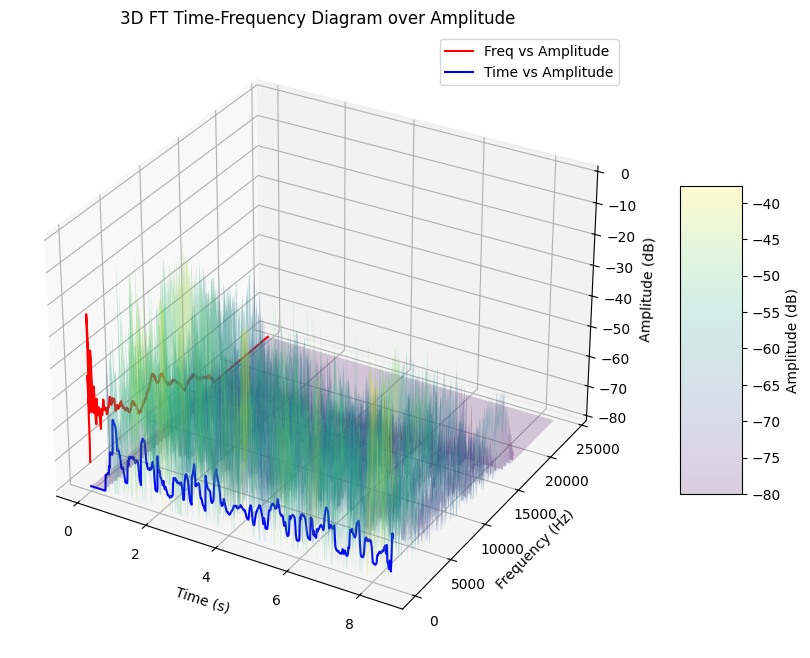

In [236]:
S = np.abs(librosa.stft(x))
S_dB = librosa.amplitude_to_db(S, ref=np.max)

times = librosa.frames_to_time(np.arange(S_dB.shape[1]), sr=sr)
frequencies = librosa.fft_frequencies(sr=sr)


fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
T, F = np.meshgrid(times, frequencies)
surf = ax.plot_surface(T, F, S_dB, cmap='viridis', alpha=0.2)

avg_amplitude_freq = np.mean(S_dB, axis=1)
ax.plot(np.zeros_like(frequencies), frequencies, avg_amplitude_freq, color='red', label='Freq vs Amplitude')

avg_amplitude_time = np.mean(S_dB, axis=0)
ax.plot(times, np.zeros_like(times), avg_amplitude_time, color='blue', label='Time vs Amplitude')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_zlabel('Amplitude (dB)')
ax.set_title('3D FT Time-Frequency Diagram over Amplitude')
ax.legend()

cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Amplitude (dB)')

plt.show()

#### Chromagram with various methods

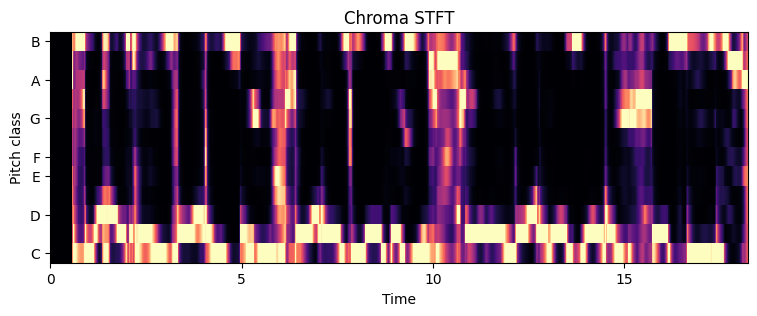

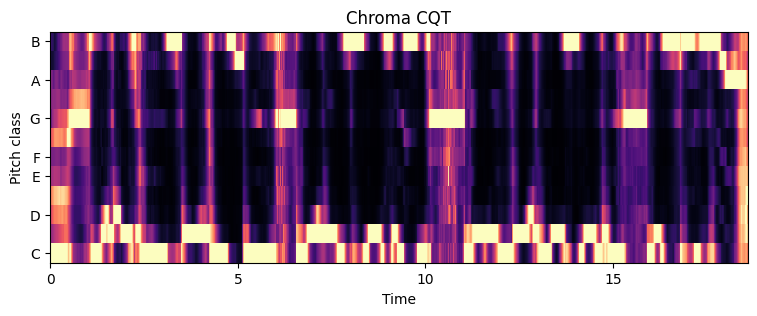

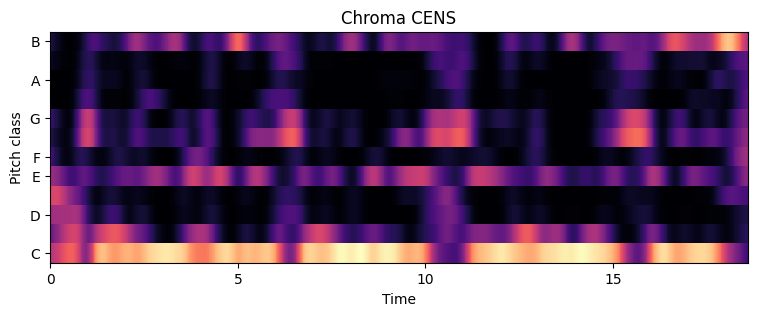

In [155]:
chroma_stft_orig =librosa.feature.chroma_stft(y=x, sr=sr, n_fft=n_fft, center=False)
plt.figure(figsize=(9, 3))
librosa.display.specshow(chroma_stft_orig, x_axis='time', y_axis='chroma')
plt.title('Chroma STFT')
plt.show()

chroma_cqt = librosa.feature.chroma_cqt(y=x, sr=sr)
plt.figure(figsize=(9, 3))
librosa.display.specshow(chroma_cqt, x_axis='time', y_axis='chroma')
plt.title('Chroma CQT')
plt.show()

cqt = np.abs(librosa.cqt(y=x, sr=sr))
chroma_cens = librosa.feature.chroma_cens(C=cqt, sr=sr)
plt.figure(figsize=(9, 3))
librosa.display.specshow(chroma_cens, x_axis='time', y_axis='chroma')
plt.title('Chroma CENS')
plt.show()

#### Spectrogram for different Spectral representation
Spectrogram that converts the amplitude spectrogram to a decibel scale for better visualization.

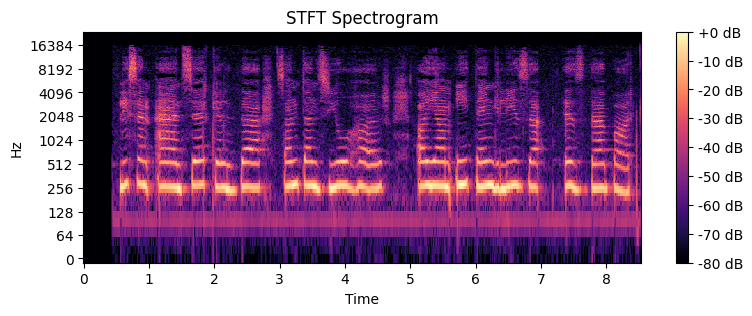

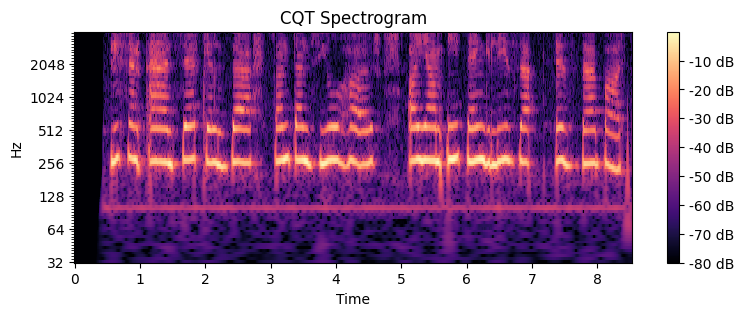

In [162]:
# STFT
plt.figure(figsize=(9, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Spectrogram')
plt.show()

# Constant-Q
C_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)
plt.figure(figsize=(9, 3))
librosa.display.specshow(C_db, sr=sr, x_axis='time', y_axis='cqt_hz', bins_per_octave=12)
plt.colorbar(format='%+2.0f dB')
plt.title('CQT Spectrogram')
plt.show()

A chromagram is a representation of the 12 different pitch classes of a musical signal, providing a summary of the harmonic content of the audio. It is especially useful for analyzing harmonic features and tonal content in music. For a given segment of audio, the Fast Fourier Transform (FFT) produces a series of frequency bins, each representing the amplitude of a specific frequency range. After obtaining the frequency bins from the STFT, the next step is to map these bins to their respective pitch classes. 
In the chromagram above, the red represents higher values or stronger magnitudes. This means that the pitch classes or time frames with light coloring have a higher energy in the audio signal. 

CENS has been proved to be effective in speech related recognition due to its vivid energy separated from the rest of the pitch class, it gives more rooms to identify the words, however in our experiment, STFT would be sufficient to provide the digital print of the audio signal for us to recognize the identity of the speaker. 

## Root Mean Square (RMS)
This section discuss one of the important extraction feature in this report - RMS. 

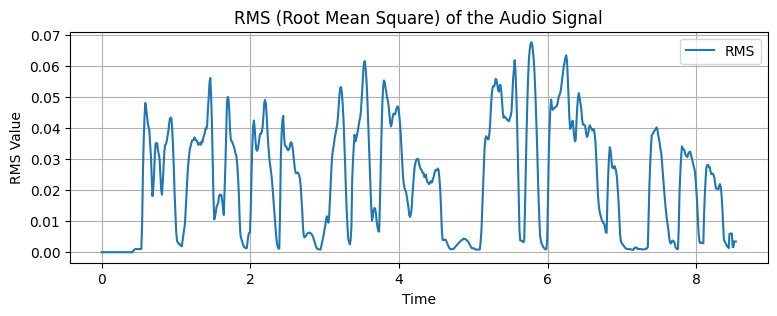

In [233]:
rms = librosa.feature.rms(y=x)[0]
times = librosa.times_like(rms, sr=sr)

plt.figure(figsize=(9, 3))
plt.plot(times, rms, label='RMS')
plt.xlabel('Time')
plt.ylabel('RMS Value')
plt.title('RMS (Root Mean Square) of the Audio Signal')
plt.legend()
plt.grid(True)
plt.show()

## Mel Frequency Cepstral Coefficients (MFCCs)
This section discuss one of the important extraction feature in this report - MFCCs. 

(20, 801)


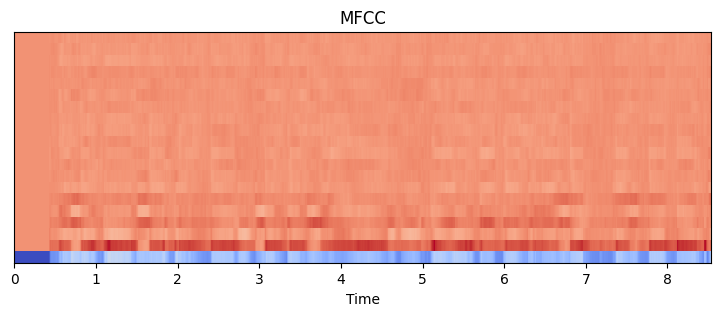

In [158]:
 mfccs = librosa.feature.mfcc(y=x, sr=sr)
print(mfccs.shape)
plt.figure(figsize=(9, 3))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.title('MFCC')
plt.show()

The shape of the MFCC indicating there are 20 MFCCs over 368 frames. 

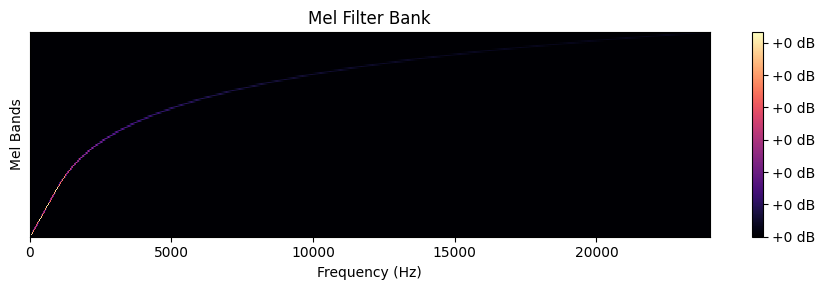

In [159]:
n_mels = 128 # range from 20-128 Mel Bands
fmin = 0
fmax = sr / 2

mel_filters = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax)

plt.figure(figsize=(9, 3))
librosa.display.specshow(mel_filters, sr=sr, x_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Filter Bank')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mel Bands')
plt.tight_layout()
plt.show()

The Mel scale is designed to match human auditory perception, so the choice of n_mels should capture the important perceptual features of the audio. Typically between 20 to 128 Mel bands. 

[-3.4884715e-07  4.7624185e-09 -3.8099348e-08 -1.0001079e-07
 -2.8574512e-08 -1.9049674e-08 -9.2867161e-08  4.7624187e-08
  0.0000000e+00  6.6673863e-08 -1.1906047e-08 -7.6198695e-08
  1.1191683e-07  2.3812094e-08 -9.5248369e-09 -4.7624187e-08
  0.0000000e+00  7.6198695e-08 -7.5008096e-08 -7.6198695e-08]


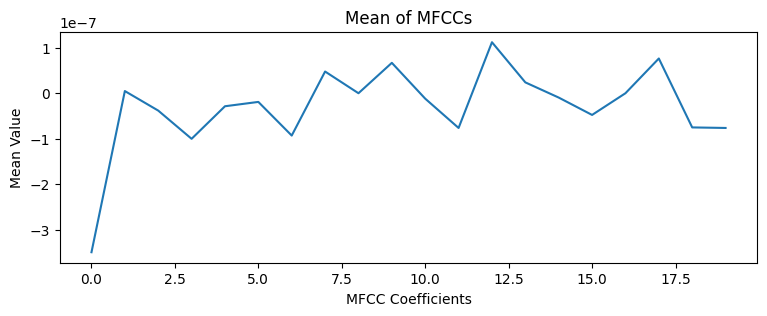

In [160]:
mfccs_scaled = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / (np.std(mfccs, axis=1, keepdims=True) + 1e-6)
mfccs_mean = np.mean(mfccs_scaled, axis=1)
print(mfccs_mean)

plt.figure(figsize=(9, 3))
plt.plot(mfccs_mean)
plt.title('Mean of MFCCs')
plt.xlabel('MFCC Coefficients')
plt.ylabel('Mean Value')
plt.show()

The MFCCs are normalized by subtracting the mean and dividing by the standard deviation along each coefficient starting from axis 1.

## Save Features to CSV
Finally, save the extracted features to a CSV file for later use in machine learning tasks.